In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import copy
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import *
from nmf import nmf
from graph_utility import graph_util

%load_ext autoreload
%autoreload 2

**In this experiment we use real COVID-19 case data for a collection of contiguous US Counties (found in covid_dataset/us_county/) to see if Diffusion-NMF might recover trends not seen by NMF.** 

### Graphing preliminaries

In [2]:
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

# custom hex list for colormap
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
# get custom features from graph_util
graph_tool = graph_util()
linestyles_dict = graph_tool.linestyles()
my_pal = graph_tool.custom_map(h_list)

## New England + New York County Data

Firstly, we take a look at the New England region (including New York). We found this to be a nice area to look at given that there are many states contained within this relatively small region. This on top of the fact that New York has consistently been a hotspot for COVID makes this region very interesting to study. States included are: New York, Connecticut, Maine, Vermont, Massachusetts, New Hampshire, and Rhode Island.

In [3]:
 # importing data
new_eng_dataset = pd.read_csv(os.path.join(par, "covid_dataset/us_county/dataset.csv"), index_col = [0,1,2])
new_eng_laplacian = pd.read_csv(os.path.join(par, "covid_dataset/us_county/laplacian.csv"), index_col = 0)
new_eng_laplacian.columns = new_eng_laplacian.columns.astype(np.int64)
new_eng_laplacian.index = new_eng_laplacian.index.astype(np.int64)
new_eng_population = pd.read_csv(os.path.join(par, "covid_dataset/us_county/population.csv"), index_col = [0,1,2,3])
#new_eng_population.loc[:, 'population_estimate'] = population.loc[:, 'population_estimate'].astype(np.float64)

# json file with geographic info for each state -- required for graphing
new_eng_map = os.path.join(par, 'covid_dataset/us_county/new_england_geography.json')

In [4]:
# I will stick with FIPS codes as a naming convention. For full county name + state it's in a backwards lookup would suffice.
# filtering out the new england region counties:
new_eng_dataset = new_eng_dataset.loc[new_eng_dataset.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng_dataset.index = new_eng_dataset.index.get_level_values(2)
new_eng_population.index = new_eng_population.index.get_level_values(3)
new_eng_laplacian = new_eng_laplacian.loc[new_eng_dataset.index, new_eng_dataset.index]

**Data Cleaning/Preparation:** We perform a location-wise normalization of data with the help of separate population data. Specifically each location's set of case counts is divided the location's estimated population. This ensures that both densely and non-densely populated areas are given (to the best of our ability) equal representation within the data. 

We also use an isotonic regression on each of the columns of the data to fix any inconsistencies. Sometimes it happens that a location might falsely report a decline in cumulative cases (which shouldn't be possible given that cases can't erase themselves). We have not investigated reasons for why this may happen, but have taken precaution to ensure that these be corrected so as not to affect the output of our algorithm. More specifically, for each location an isotonic regression fits a new line (not necessarily linear or continuous) which not only matches the data points which are already increasing, but also makes sure to correct any decreasing data points, giving them new values that enforce the strictly increasing constraint. Any location whose data does not contain errors is not changed. 

In [5]:
# Normalize by population
new_eng_dataset = new_eng_dataset.T

for col in new_eng_dataset.columns:
    new_eng_dataset.loc[:,col] /= new_eng_population.loc[col, 'population_estimate'].item()
    
# perfrom isotonic regression to fix inconsitencies:
new_eng_dataset = iso_regression(new_eng_dataset)

### Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. What is shown is a pre-saved image of the results. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

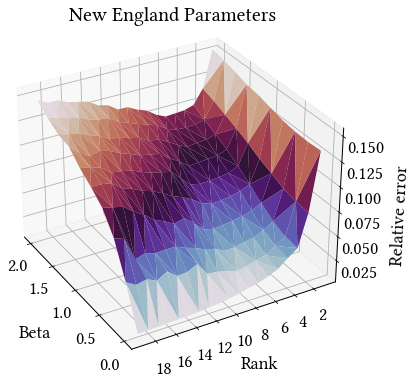

In [11]:
new_eng_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/new_eng_rank_beta.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("New England Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

In our paper we have chosen to use the parameter combination of rank = 5, beta = 1. This was chosen for several reasons, not all of which are determined by the error analysis shown above. The rank, however, does show a nice canyon around the region of rank = [4-6] in the figure. For this reason we chose a value of 5 which also tended to produce good looking waves. The beta (spread) parameter is more difficult to choose for. A very small beta value is the equivalent to a miniscule diffusion process. As the parameter goes to 0 the error continues to decrease but the solution approaches the one seen from NMF because the inclusion of a diffusion matrix is really only a constraint built upon standard NMF. For this reason it's important to choose a parameter value that not only does reasonably well in minimizing error, but is also large enough to reflect the assumption that there is some diffusion process happening. We chose the value of 1 as a nice middle ground.

### Results

In [24]:
# prepare parameters
rank = 5
beta = 1
ne_K = np.linalg.inv(np.identity(len(new_eng_laplacian)) + beta * new_eng_laplacian.to_numpy())

# diffusion nmf (takes a minute or so)
dNMF = diff_nmf(n_components = rank, kernel = ne_K, n_iter = 200000  , tol = 1e-10)
ne_X,ne_V = dNMF.fit_transform(new_eng_dataset)

Max iterations reached, increase to converge on given tolerance


In [25]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
ne_W,ne_H = nmfer.fit_transform(new_eng_dataset)

Max iterations reached, increase to converge on given tolerance


In [26]:
#rescaling
ne_X,ne_V = rescale(ne_X,ne_V)
ne_X = pd.DataFrame(ne_X, index = new_eng_dataset.index)
ne_V = pd.DataFrame(ne_V, columns = new_eng_dataset.columns)

ne_W,ne_H = rescale(ne_W,ne_H)
ne_W = pd.DataFrame(ne_W, index = new_eng_dataset.index)
ne_H = pd.DataFrame(ne_H, columns = new_eng_dataset.columns)

**Note that for side by side comparison later you'd need to re order the waves here so that similar waves are compared together.** For best comparison please see the figures included in our paper, but feel free to use whats given below to re-order it for yourself. Simply change the order of waves by changing the re-order list below. I wish I had a nice method to automate this, but haven't found one yet. My tactic is to order them by time-wise appearance of waves. The very first wave to see some sort of peak (even if its very small) is wave 0, next is wave 1, etc. Note that the outputs from NMF and DNMF must be ordered separately.

In [30]:
# RE-order for better presentation
ne_X.columns = ["Wave " + str(i) for i in range(rank)]
ne_W.columns = ["Wave " + str(i) for i in range(rank)]
ne_V.index = ["Wave " + str(i) for i in range(rank)]
ne_H.index = ["Wave " + str(i) for i in range(rank)]

standard = ne_X.columns
reorder = ['Wave 4', 'Wave 2', 'Wave 0', 'Wave 1', 'Wave 3']
ne_X = ne_X[reorder]
ne_X.columns = standard
ne_V = ne_V.reindex(reorder)
ne_V.index = standard 

# RE-order for better presentation
standard = ne_W.columns
reorder = ['Wave 2', 'Wave 1', 'Wave 0', 'Wave 4', 'Wave 3']
ne_W = ne_W[reorder]
ne_W.columns = standard
ne_H = ne_H.reindex(reorder)
ne_H.index = standard 

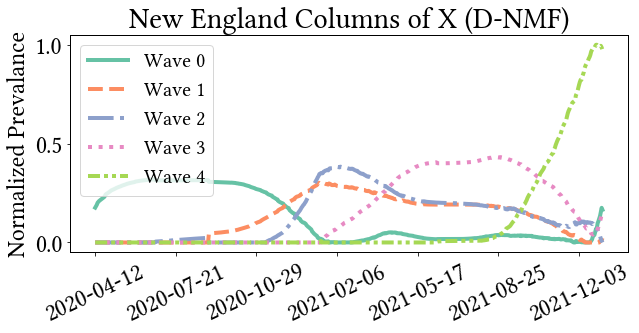

In [31]:
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
ne_X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(ne_X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = 'Wave 4')
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("New England Columns of X (D-NMF)")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

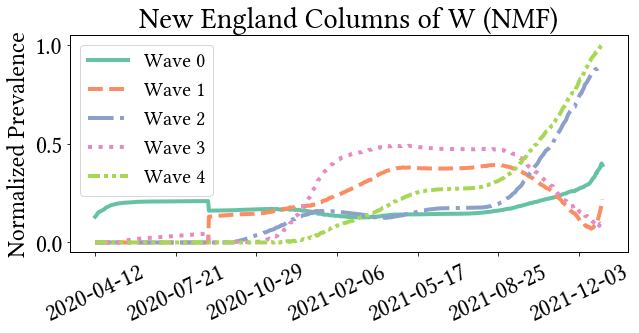

In [32]:
plt.rcParams["font.size"] = 24
ne_W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(ne_W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = 'Wave 4')
plt.legend()

plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.title("New England Columns of W (NMF)")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

The two figures above show that both NMF and D-NMF capture similar waves with only slight differences. It might be noted that peaks within curves of the D-NMF solution are a bit sharper, but the real advantage to D-NMF comes from analyzing the V matrix (shown row-by-row in map form in the figures below). 

Text(0.5, 1.0, 'Row 2 of V (D-NMF)')

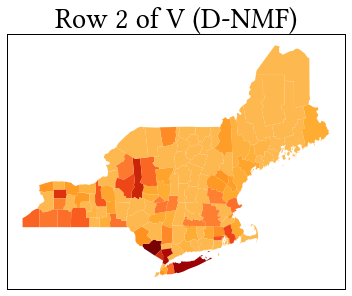

In [42]:
newEngMap = gp.read_file(new_eng_map)

row_num = 2

val_col1 = []

for i in newEngMap["id"]:
    try:
        val_col1.append(ne_V.loc["Wave " + str(row_num),int(i)])
    except:
        val_col1.append(np.nan)

newEngMap['val1'] = val_col1

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

newEngMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of V (D-NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_V' + str(row_num) + '.pdf', bbox_inches = "tight")

Text(0.5, 1.0, 'Row 3 of H (NMF)')

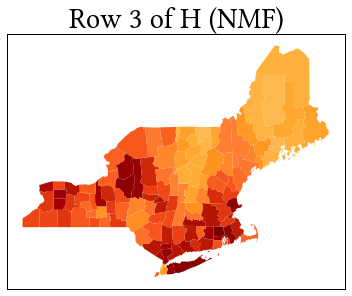

In [44]:
newEngMap = gp.read_file(new_eng_map)
val_col = []
row_num = 3
for i in newEngMap["id"]:
    try:
        val_col.append(ne_H.loc["Wave " + str(row_num),int(i)])
    except:
        val_col.append(np.nan)

newEngMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
newEngMap.plot(column='val', legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of H (NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_H' + str(row_num) + '.pdf', bbox_inches = "tight")

Changing the row_num parameter in the two cells above allows you to view maps which correspond to other waves or rows of V/H. For most it is clear that the D-NMF solution does a better job of highlighting origin points or centers of diffusion within the data. Whereas NMF solutions have coefficients which are very similar to each other, there are sharper contrasts between certain counties and their neighbors in the D-NMF solutions. If our hypotheses are correct, these states colored in darker red are locations from which their respective wave either originated or had a larger than normal effect. 

### Error Checking

In [45]:
new_eng_diff_error = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/new_eng_diff_rank.csv"))
new_eng_nmf_error = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/new_eng_nmf_rank.csv"))

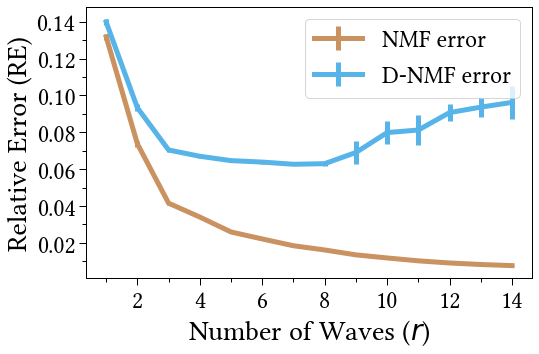

In [46]:
c_pal = sns.color_palette("colorblind", 10)
plt.rcParams['legend.fontsize'] = 24
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, new_eng_nmf_error["relative error"], new_eng_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, new_eng_diff_error["relative error"], new_eng_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()

Seen above is a comparison between NMF and D-NMF for recovery error. More specifically, we solved both NMF and D-NMF using the same input data but varied the rank parameter. After obtaining solutions we took the products of W and H (from NMF) and the products of X, V, and K (from D-NMF) and compared them to the original data. The difference between the original and the recovered solution is what is shown in the graph above. Note that NMF consistently outperforms D-NMF. This was to be expected given that D-NMF is essentially a further constraint built upon NMF. 

# California Counties

For the second experiment on the county level we chose to analyze California counties. California is a particularly large state which has been uniquely affected by COVID-19 which makes it interesting for study

In [47]:
 # importing data
cali_dataset = pd.read_csv(os.path.join(par, "covid_dataset/us_county/dataset.csv"), index_col = [0,1,2])
cali_laplacian = pd.read_csv(os.path.join(par, "covid_dataset/us_county/laplacian.csv"), index_col = 0)
cali_laplacian.columns = cali_laplacian.columns.astype(np.int64)
cali_laplacian.index = cali_laplacian.index.astype(np.int64)
cali_population = pd.read_csv(os.path.join(par, "covid_dataset/us_county/population.csv"), index_col = [0,1,2,3])

# json file with geographic info for each state -- required for graphing
cali_map = os.path.join(par, 'covid_dataset/us_county/california_geography.json')

In [48]:
# I will stick with FIPS codes as a naming convention. For full county name + state it's in a backwards lookup would suffice.
# filtering out the new england region counties:
cali_dataset = cali_dataset.loc[cali_dataset.index.get_level_values("state").isin(["California"])]
cali_dataset.index = cali_dataset.index.get_level_values(2)
cali_population.index = cali_population.index.get_level_values(3)
cali_laplacian = cali_laplacian.loc[cali_dataset.index, cali_dataset.index]

In [49]:
# SAME DATA CLEANING procedures as described above for New England
# Normalize by population
cali_dataset = cali_dataset.T

for col in cali_dataset.columns:
    cali_dataset.loc[:,col] /= cali_population.loc[col, 'population_estimate'].item()
    
# perfrom isotonic regression to fix inconsitencies:
cali_dataset = iso_regression(cali_dataset)

### Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. What is shown is a pre-saved image of the results. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

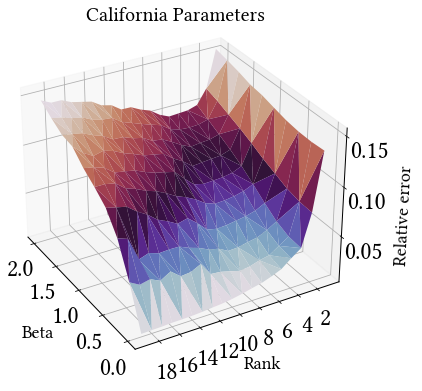

In [32]:
cali_grid = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/california_rank_beta.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("California Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

For use in our paper we have selected the parameter combination of Rank = 3, Beta = 1. Again this choice is mostly heuristic. However in the above figure it is fairly easy to see that the error forms a nice canyon around the regions of rank = [3 - 6]. We stuck with 3 simply because a rank greater than 3 tended to show redundant waves within the output. Again Beta (spread parameter) is a tough choice and we chose to stick with the middle ground value of 1 (For reasons same as described above).

### Results:

In [50]:
# prepare parameters
rank = 3
beta = 1
cK = np.linalg.inv(np.identity(len(cali_laplacian)) + beta * cali_laplacian.to_numpy())

# diffusion nmf (takes a minute or so)
dNMF = diff_nmf(n_components = rank, kernel = cK, n_iter = 200000  , tol = 1e-10)
cX,cV = dNMF.fit_transform(cali_dataset)

In [51]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
cW,cH = nmfer.fit_transform(cali_dataset)

In [53]:
#rescaling
cX,cV = rescale(cX,cV)
cX = pd.DataFrame(cX, index = cali_dataset.index)
cV = pd.DataFrame(cV, columns = cali_dataset.columns)

cW,cH = rescale(cW,cH)
cW = pd.DataFrame(cW, index = cali_dataset.index)
cH = pd.DataFrame(cH, columns = cali_dataset.columns)

**Note that for side by side comparison later you'd need to re order the waves here so that similar waves are compared together.** For best comparison please see the figures included in our paper, but feel free to use whats given below to re-order it for yourself. Simply change the order of waves by changing the re-order list below. I wish I had a nice method to automate this, but haven't found one yet. My tactic is to order them by time-wise appearance of waves. The very first wave to see some sort of peak (even if its very small) is wave 0, next is wave 1, etc. Note that the outputs from NMF and DNMF must be ordered separately.

In [57]:
# RE-orderering of columns for better presentation
cX.columns = ["Wave " + str(i) for i in range(rank)]
cW.columns = ["Wave " + str(i) for i in range(rank)]
cV.index = ["Wave " + str(i) for i in range(rank)]
cH.index = ["Wave " + str(i) for i in range(rank)]

standard = cX.columns
reorder = ['Wave 1', 'Wave 2', 'Wave 0']
cX = cX[reorder]
cX.columns = standard
cV = cV.reindex(reorder)
cV.index = standard 

# RE-order for better presentation
standard = cW.columns
reorder = ['Wave 1', 'Wave 2', 'Wave 0']
cW = cW[reorder]
cW.columns = standard
cH = cH.reindex(reorder)
cH.index = standard 

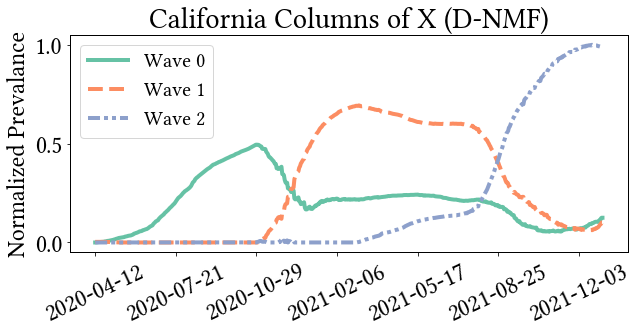

In [58]:
cX.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
cX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(cX.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 2")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("California Columns of X (D-NMF)")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

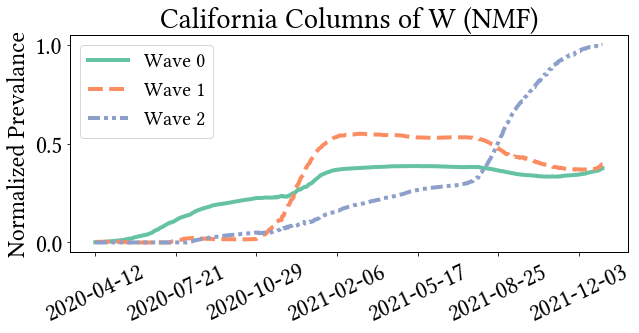

In [59]:
cW.columns = ["Wave " + str(i) for i in range(rank)]

plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
cW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(cW.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 2")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("California Columns of W (NMF)")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

The two figures above show that both NMF and D-NMF capture similar waves with only slight differences. It might be noted that peaks within curves of the D-NMF solution are a bit sharper, but the real advantage to D-NMF comes from analyzing the V matrix (shown row-by-row in map form in the figures below). 

Text(0.5, 1.0, 'Row 2 of V (D-NMF)')

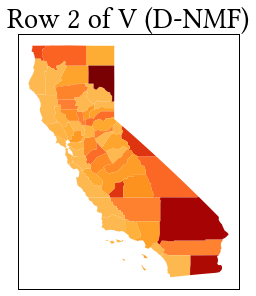

In [60]:
caliMap = gp.read_file(cali_map)

row_num = 2

val_col1 = []

for i in caliMap["id"]:
    try:
        val_col1.append(cV.loc["Wave " + str(row_num),int(i)])
    except:
        val_col1.append(np.nan)

caliMap['val1'] = val_col1

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

caliMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of V (D-NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_V' + str(row_num) + '.pdf', bbox_inches = "tight")

Text(0.5, 1.0, 'Row 2 of H (NMF)')

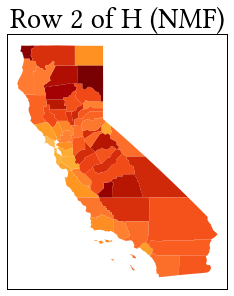

In [61]:
caliMap = gp.read_file(cali_map)
val_col = []
row_num = 2
for i in caliMap["id"]:
    try:
        val_col.append(cH.loc["Wave " + str(row_num),int(i)])
    except:
        val_col.append(np.nan)

caliMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
caliMap.plot(column='val', legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("Row " + str(row_num) + " of H (NMF)")

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_H' + str(row_num) + '.pdf', bbox_inches = "tight")

Changing the row_num parameter in the two cells above allows you to view maps which correspond to other waves or rows of V/H. For most it is clear that the D-NMF solution does a better job of highlighting origin points or centers of diffusion within the data. Whereas NMF solutions have coefficients which are very similar to each other, there are sharper contrasts between certain counties and their neighbors in the D-NMF solutions. If our hypotheses are correct, these states colored in darker red are locations from which their respective wave either originated or had a larger than normal effect. 

### Error Checking

In [49]:
cali_diff_error = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/california_diff_rank.csv"))
cali_nmf_error = pd.read_csv(os.path.join(par, "covid_dataset/us_county/grid_search_results/california_nmf_rank.csv"))

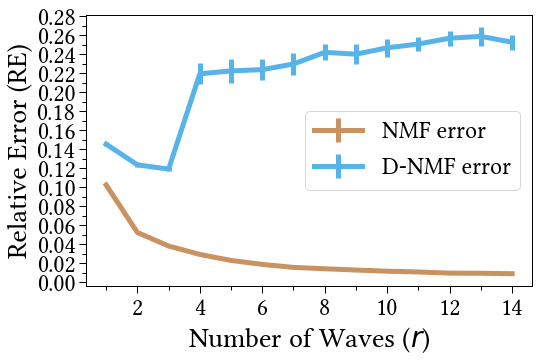

In [50]:
c_pal = sns.color_palette("colorblind", 10)
plt.rcParams['legend.fontsize'] = 24
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, cali_nmf_error["relative error"], cali_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, cali_diff_error["relative error"], cali_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()

Seen above is a comparison between NMF and D-NMF for recovery error. More specifically, we solved both NMF and D-NMF using the same input data but varied the rank parameter. After obtaining solutions we took the products of W and H (from NMF) and the products of X, V, and K (from D-NMF) and compared them to the original data. The difference between the original and the recovered solution is what is shown in the graph above. Note that NMF consistently outperforms D-NMF. This was to be expected given that D-NMF is essentially a further constraint built upon NMF. 